In [3]:
import os, re

BASE = "/Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder"

FOLDERS = {
    "physics_chapters":   f"{BASE}/physics_chapters_cleaned",
    "physics_pages":      f"{BASE}/physics_pages",
    "chemistry_chapters": f"{BASE}/chemistry_chapters_cleaned",
    "chemistry_pages":    f"{BASE}/chemistry_pages",
    "biology_chapters":   f"{BASE}/biology_chapters_cleaned",
    "biology_pages":      f"{BASE}/biology_pages",
}

FORMULA_RE = re.compile(r"\$\$(.*?)\$\$", flags=re.DOTALL)

def strip_formulas(text: str) -> str:
    return FORMULA_RE.sub(" ", text)

documents = {}
for label, folder in FOLDERS.items():
    if not os.path.isdir(folder):
        print(f"[WARN] Missing folder: {folder}")
        continue
    for fname in sorted(os.listdir(folder)):
        if fname.endswith(".md"):
            path = os.path.join(folder, fname)
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                raw = f.read()
            documents[f"{label}/{fname}"] = strip_formulas(raw).lower()

print(f"Loaded {len(documents)} files.")
list(documents.keys())[:5]


Loaded 4435 files.


['physics_chapters/chapter_01.md',
 'physics_chapters/chapter_02.md',
 'physics_chapters/chapter_03.md',
 'physics_chapters/chapter_04.md',
 'physics_chapters/chapter_05.md']

I import os and re for file systems and regex, defining locations and base directories as i need a consistent map from semantic groups to actual folders on disk.

I use Formula_re to get anything between "$...$$" to remove all the formulas from the markdown files.

Now I Load all documents into one dictionary, while doing some processes on each md file:- reading md, striping formula, conversing to lowercase and finally storing it, that we'll compare to every other document


In [2]:
import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    nlp = spacy.blank("en")
    from spacy.lang.en.stop_words import STOP_WORDS
    nlp.Defaults.stop_words |= STOP_WORDS

nlp.max_length = max(getattr(nlp, "max_length", 1_000_000), 10_000_000)


I use spacy as being a tokenizer and stopword provider it helps in processing the text


In [3]:
from collections import Counter
from tqdm.auto import tqdm

stats = {}
names = list(documents.keys())
texts = [documents[n] for n in names]

DISABLE = ["tagger", "parser", "ner", "attribute_ruler", "lemmatizer"]
BATCH = 100

for name, doc in tqdm(
    zip(names, nlp.pipe(texts, batch_size=BATCH, disable=DISABLE)),
    total=len(names), desc="Token stats", smoothing=0.1
):
    toks_all = [t.text for t in doc if not t.is_space]
    toks_no_stop = [t.text for t in doc if t.is_alpha and not t.is_stop]

    stats[name] = {
        "total_tokens": len(toks_all),
        "unique_tokens": len(set(toks_all)),
        "total_no_stop": len(toks_no_stop),
        "unique_no_stop": len(set(toks_no_stop)),
    }
next(iter(stats.items()))


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Token stats: 100%|██████████| 4435/4435 [02:35<00:00, 28.55it/s]


('physics_chapters/chapter_01.md',
 {'total_tokens': 16670,
  'unique_tokens': 2612,
  'total_no_stop': 6477,
  'unique_no_stop': 1996})

We use nlp.pipe to process documents in batches (efficient) with most heavy components disabled (no parsing, tagging, etc.)

For each doc, i am storing: total tokens, unique tokens, total non-stop tokens and unique non-stop tokens in stats.

This gives us a basic lexical statistics for each chapter/page: length, vocabulary richness, etc. These can be used to argue:
- Some subjects/chapters are much denser (more tokens).
- Some chapters reuse vocabulary heavily (low unique/total ratio).

In [4]:
# Builds a DTM (rows=docs, cols=terms) from content tokens; toggle lemmas for better matching across word forms.

import pandas as pd
from collections import Counter

USE_LEMMAS = False  # True → use t.lemma_ (requires lemmatizer); False → use t.text (faster)

DISABLE_DTM = ["tagger", "parser", "ner", "attribute_ruler", "lemmatizer"]

term_counts = {}
for name, doc in tqdm(
    zip(names, nlp.pipe(texts, batch_size=BATCH, disable=DISABLE_DTM)),
    total=len(names), desc=f"DTM ({'lemmas' if USE_LEMMAS else 'tokens'})", smoothing=0.1
):
    toks = [t.text   for t in doc if t.is_alpha and not t.is_stop]
    term_counts[name] = Counter(toks)

dtm = pd.DataFrame.from_dict(term_counts, orient="index").fillna(0).astype(int)
dtm = dtm.reindex(sorted(dtm.columns), axis=1).fillna(0).astype(int)

dtm.shape, dtm.iloc[:3, :8]

DTM (tokens): 100%|██████████| 4435/4435 [02:35<00:00, 28.56it/s]


((4368, 29363),
                                 aa  aaa  aabb  aabbcc  aacc  aag  aand  aany
 physics_chapters/chapter_01.md   0    0     0       0     0    0     0     0
 physics_chapters/chapter_02.md   0    0     0       0     0    0     0     0
 physics_chapters/chapter_03.md   0    0     0       0     0    0     0     0)

We reprocess all text using spaCy to collect alpha-only, non-stopword tokens, then build a document-term matrix (DTM) where each document is represented as a vector of term frequencies. This DTM forms the foundation for bag-of-words similarity calculations like Jaccard, Pearson, and TF-IDF cosine. As USE_LEMMAS = False, different word forms (e.g., field vs fields) are treated separately, which speeds up processing but could be enhanced via lemmatization in future iterations.

In [5]:
import os
out_dir = os.path.join(BASE, "_outputs"); os.makedirs(out_dir, exist_ok=True)

In [6]:
import numpy as np

doc_names = list(dtm.index)
doc_sets = {d: set(term_counts[d].keys()) for d in doc_names}

n = len(doc_names)
jaccard = np.zeros((n, n), dtype=float)
for i in range(n):
    A = doc_sets[doc_names[i]]
    for j in range(n):
        B = doc_sets[doc_names[j]]
        jaccard[i, j] = 100.0 * len(A & B) / len(A | B) if (A or B) else 0.0

jaccard_df = pd.DataFrame(jaccard, index=doc_names, columns=doc_names)
jaccard_df.round(1).iloc[:8, :8]


physics_chapters/chapter_01.md  \
physics_chapters/chapter_01.md                           100.0   
physics_chapters/chapter_02.md                            25.0   
physics_chapters/chapter_03.md                            21.7   
physics_chapters/chapter_04.md                            26.7   
physics_chapters/chapter_05.md                            21.4   
physics_chapters/chapter_06.md                            25.7   
physics_chapters/chapter_07.md                            23.9   
physics_chapters/chapter_08.md                            22.0   

                                physics_chapters/chapter_02.md  \
physics_chapters/chapter_01.md                            25.0   
physics_chapters/chapter_02.md                           100.0   
physics_chapters/chapter_03.md                            32.0   
physics_chapters/chapter_04.md                            31.0   
physics_chapters/chapter_05.md                            25.3   
physics_chapters/chapter_06.md                            28.1   
physics_chapters/chapter_07.md                            28.8   
physics_chapters/chapter_08.md                            29.3   

                                physics_chapters/chapter_03.md  \
physics_chapters/chapter_01.md                            21.7   
physics_chapters/chapter_02.md                            32.0   
physics_chapters/chapter_03.md                           100.0   
physics_chapters/chapter_04.md                            27.4   
physics_chapters/chapter_05.md                            23.2   
physics_chapters/chapter_06.md                            27.3   
physics_chapters/chapter_07.md                            23.6   
physics_chapters/chapter_08.md                            28.0   

                                physics_chapters/chapter_04.md  \
physics_chapters/chapter_01.md                            26.7   
physics_chapters/chapter_02.md                            31.0   
physics_chapters/chapter_03.md                            27.4   
physics_chapters/chapter_04.md                           100.0   
physics_chapters/chapter_05.md                            27.9   
physics_chapters/chapter_06.md                            31.6   
physics_chapters/chapter_07.md                            28.8   
physics_chapters/chapter_08.md                            30.6   

                                physics_chapters/chapter_05.md  \
physics_chapters/chapter_01.md                            21.4   
physics_chapters/chapter_02.md                            25.3   
physics_chapters/chapter_03.md                            23.2   
physics_chapters/chapter_04.md                            27.9   
physics_chapters/chapter_05.md                           100.0   
physics_chapters/chapter_06.md                            26.3   
physics_chapters/chapter_07.md                            26.5   
physics_chapters/chapter_08.md                            25.0   

                                physics_chapters/chapter_06.md  \
physics_chapters/chapter_01.md                            25.7   
physics_chapters/chapter_02.md                            28.1   
physics_chapters/chapter_03.md                            27.3   
physics_chapters/chapter_04.md                            31.6   
physics_chapters/chapter_05.md                            26.3   
physics_chapters/chapter_06.md                           100.0   
physics_chapters/chapter_07.md                            27.2   
physics_chapters/chapter_08.md                            27.9   

                                physics_chapters/chapter_07.md  \
physics_chapters/chapter_01.md                            23.9   
physics_chapters/chapter_02.md                            28.8   
physics_chapters/chapter_03.md                            23.6   
physics_chapters/chapter_04.md                            28.8   
physics_chapters/chapter_05.md                            26.5   
physics_chapters/chapter_06.md                            27.2   


We are finding out the Jackard similarity here, Jaccard measures “vocabulary overlap” ignoring frequencies. This similarity metrix is perfect for answering the question, “Do these two chapters talk about similar concepts at all?”


In [7]:
corr_df = dtm.T.corr(method="pearson") * 100.0
corr_df.round(1).iloc[:8, :8]

#taking too much time so finding cosine similarity would be better, if still needed i will do in end

physics_chapters/chapter_01.md  \
physics_chapters/chapter_01.md                           100.0   
physics_chapters/chapter_02.md                            29.2   
physics_chapters/chapter_03.md                            20.7   
physics_chapters/chapter_04.md                            28.1   
physics_chapters/chapter_05.md                            24.2   
physics_chapters/chapter_06.md                            30.6   
physics_chapters/chapter_07.md                            19.1   
physics_chapters/chapter_08.md                            24.1   

                                physics_chapters/chapter_02.md  \
physics_chapters/chapter_01.md                            29.2   
physics_chapters/chapter_02.md                           100.0   
physics_chapters/chapter_03.md                            57.3   
physics_chapters/chapter_04.md                            32.2   
physics_chapters/chapter_05.md                            31.2   
physics_chapters/chapter_06.md                            46.1   
physics_chapters/chapter_07.md                            18.9   
physics_chapters/chapter_08.md                            41.2   

                                physics_chapters/chapter_03.md  \
physics_chapters/chapter_01.md                            20.7   
physics_chapters/chapter_02.md                            57.3   
physics_chapters/chapter_03.md                           100.0   
physics_chapters/chapter_04.md                            31.9   
physics_chapters/chapter_05.md                            28.5   
physics_chapters/chapter_06.md                            35.6   
physics_chapters/chapter_07.md                            15.7   
physics_chapters/chapter_08.md                            34.6   

                                physics_chapters/chapter_04.md  \
physics_chapters/chapter_01.md                            28.1   
physics_chapters/chapter_02.md                            32.2   
physics_chapters/chapter_03.md                            31.9   
physics_chapters/chapter_04.md                           100.0   
physics_chapters/chapter_05.md                            67.9   
physics_chapters/chapter_06.md                            65.4   
physics_chapters/chapter_07.md                            33.6   
physics_chapters/chapter_08.md                            45.0   

                                physics_chapters/chapter_05.md  \
physics_chapters/chapter_01.md                            24.2   
physics_chapters/chapter_02.md                            31.2   
physics_chapters/chapter_03.md                            28.5   
physics_chapters/chapter_04.md                            67.9   
physics_chapters/chapter_05.md                           100.0   
physics_chapters/chapter_06.md                            54.3   
physics_chapters/chapter_07.md                            31.7   
physics_chapters/chapter_08.md                            39.7   

                                physics_chapters/chapter_06.md  \
physics_chapters/chapter_01.md                            30.6   
physics_chapters/chapter_02.md                            46.1   
physics_chapters/chapter_03.md                            35.6   
physics_chapters/chapter_04.md                            65.4   
physics_chapters/chapter_05.md                            54.3   
physics_chapters/chapter_06.md                           100.0   
physics_chapters/chapter_07.md                            27.5   
physics_chapters/chapter_08.md                            43.6   

                                physics_chapters/chapter_07.md  \
physics_chapters/chapter_01.md                            19.1   
physics_chapters/chapter_02.md                            18.9   
physics_chapters/chapter_03.md                            15.7   
physics_chapters/chapter_04.md                            33.6   
physics_chapters/chapter_05.md                            31.7   
physics_chapters/chapter_06.md                            27.5   


We are computing correlation metrix between chapters and pages using dtm metrices, This gives a Pearson correlation (%) between term-count vectors.


In [8]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

docs_order = list(term_counts.keys())
corpus_for_tfidf = [" ".join([tok for tok, c in term_counts[name].items() for _ in range(c)])
                    for name in docs_order]

tfidf = TfidfVectorizer(lowercase=False, token_pattern=r"(?u)\b\w+\b")
X_tfidf = tfidf.fit_transform(corpus_for_tfidf)
n = X_tfidf.shape[0]
sim = np.zeros((n, n), dtype=np.float32)
tile = 500

pbar = tqdm(total=n, desc="Cosine TF-IDF tiles")
start = 0
while start < n:
    end = min(start + tile, n)
    block = cosine_similarity(X_tfidf[start:end], X_tfidf)
    sim[start:end, :] = block.astype(np.float32) * 100.0
    start = end
    pbar.update(block.shape[0])
pbar.close()

cosine_df = pd.DataFrame(sim, index=docs_order, columns=docs_order)
cosine_df.iloc[:8, :8].round(1)


Cosine TF-IDF tiles: 100%|██████████| 4435/4435 [00:00<00:00, 12313.66it/s]


physics_chapters/chapter_01.md  \
physics_chapters/chapter_01.md                      100.000000   
physics_chapters/chapter_02.md                       20.900000   
physics_chapters/chapter_03.md                       13.500000   
physics_chapters/chapter_04.md                       22.500000   
physics_chapters/chapter_05.md                       16.400000   
physics_chapters/chapter_06.md                       21.799999   
physics_chapters/chapter_07.md                       16.799999   
physics_chapters/chapter_08.md                       15.300000   

                                physics_chapters/chapter_02.md  \
physics_chapters/chapter_01.md                       20.900000   
physics_chapters/chapter_02.md                      100.000000   
physics_chapters/chapter_03.md                       48.900002   
physics_chapters/chapter_04.md                       31.799999   
physics_chapters/chapter_05.md                       25.100000   
physics_chapters/chapter_06.md                       39.799999   
physics_chapters/chapter_07.md                       20.700001   
physics_chapters/chapter_08.md                       33.500000   

                                physics_chapters/chapter_03.md  \
physics_chapters/chapter_01.md                       13.500000   
physics_chapters/chapter_02.md                       48.900002   
physics_chapters/chapter_03.md                      100.000000   
physics_chapters/chapter_04.md                       27.799999   
physics_chapters/chapter_05.md                       19.900000   
physics_chapters/chapter_06.md                       26.400000   
physics_chapters/chapter_07.md                       15.400000   
physics_chapters/chapter_08.md                       26.700001   

                                physics_chapters/chapter_04.md  \
physics_chapters/chapter_01.md                       22.500000   
physics_chapters/chapter_02.md                       31.799999   
physics_chapters/chapter_03.md                       27.799999   
physics_chapters/chapter_04.md                      100.000000   
physics_chapters/chapter_05.md                       53.900002   
physics_chapters/chapter_06.md                       52.900002   
physics_chapters/chapter_07.md                       35.500000   
physics_chapters/chapter_08.md                       35.099998   

                                physics_chapters/chapter_05.md  \
physics_chapters/chapter_01.md                       16.400000   
physics_chapters/chapter_02.md                       25.100000   
physics_chapters/chapter_03.md                       19.900000   
physics_chapters/chapter_04.md                       53.900002   
physics_chapters/chapter_05.md                      100.000000   
physics_chapters/chapter_06.md                       37.200001   
physics_chapters/chapter_07.md                       31.500000   
physics_chapters/chapter_08.md                       26.900000   

                                physics_chapters/chapter_06.md  \
physics_chapters/chapter_01.md                       21.799999   
physics_chapters/chapter_02.md                       39.799999   
physics_chapters/chapter_03.md                       26.400000   
physics_chapters/chapter_04.md                       52.900002   
physics_chapters/chapter_05.md                       37.200001   
physics_chapters/chapter_06.md                      100.000000   
physics_chapters/chapter_07.md                       25.400000   
physics_chapters/chapter_08.md                       30.400000   

                                physics_chapters/chapter_07.md  \
physics_chapters/chapter_01.md                       16.799999   
physics_chapters/chapter_02.md                       20.700001   
physics_chapters/chapter_03.md                       15.400000   
physics_chapters/chapter_04.md                       35.500000   
physics_chapters/chapter_05.md                       31.500000   
physics_chapters/chapter_06.md                       25.400000   


We reconstruct each document as a single string by repeating tokens according to their frequency. Next, we use TfidfVectorizer to convert these texts into TF-IDF vectors. To avoid memory issues, we compute cosine similarity in blocks of 500 documents. For each pair (i, j), we calculate the cosine similarity percentage sim[i, j] and store the full matrix in cosine_df



In [9]:
# Saves stats, DTM, and whichever similarity matrix you actually computed (corr_df or cosine_df).

import os
out_dir = os.path.join(BASE, "_outputs")
os.makedirs(out_dir, exist_ok=True)

pd.DataFrame.from_dict(stats, orient="index").to_csv(os.path.join(out_dir, "token_stats.csv"))
dtm.to_csv(os.path.join(out_dir, "dtm_counts.csv"))

saved_any_similarity = False


if "corr_df" in globals():
    corr_df.to_csv(os.path.join(out_dir, "pearson_corr_percent.csv"))
    print("Saved Pearson correlation → pearson_corr_percent.csv")
    saved_any_similarity = True


if "cosine_df" in globals():
    cosine_df.to_csv(os.path.join(out_dir, "cosine_tfidf_percent.csv"))
    print("Saved cosine TF-IDF similarity → cosine_tfidf_percent.csv")
    saved_any_similarity = True


if "jaccard_df" in globals():
    jaccard_df.to_csv(os.path.join(out_dir, "jaccard_overlap_percent.csv"))
    print("Saved Jaccard overlap → jaccard_overlap_percent.csv")

print("Saved to:", out_dir)

Saved Pearson correlation → pearson_corr_percent.csv
Saved cosine TF-IDF similarity → cosine_tfidf_percent.csv
Saved Jaccard overlap → jaccard_overlap_percent.csv
Saved to: /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs


I am just saving all the metrices as csv files so that we can use them for more analysis and to showcase outputs.


Visualization

In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(
    df,
    title,
    out_name,
    vmin=None,
    vmax=None,
    cmap="viridis",
    annotate=False,
    add_ch_labels=True,
):
    """
    If add_ch_labels=True, rows/cols are relabeled as ch1, ch2, ...
    and shown on top + left. Otherwise behaves like the original function.
    """
    plt.figure(figsize=(10, 8))

    if add_ch_labels:
        # Create short chapter labels
        short_labels = [f"ch{i+1}" for i in range(df.shape[0])]

        df_labeled = df.copy()
        df_labeled.index = short_labels
        df_labeled.columns = short_labels

        ax = sns.heatmap(
            df_labeled,
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            square=True,
            cbar=True,
            xticklabels=True,
            yticklabels=True,
            annot=annotate,
            fmt=".1f",
        )

        # Put x labels on top, y on left
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

        # Make labels readable
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation=90)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
        print("if part")

    else:
        # Original behavior (no tick labels)
        ax = sns.heatmap(
            df,
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            square=True,
            cbar=True,
            xticklabels=False,
            yticklabels=False,
            annot=annotate,
            fmt=".1f",
        )
        print("else part")

    ax.set_title(title)
    plt.tight_layout()

    out_dir = os.path.join(BASE, "_outputs")
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, out_name)
    plt.savefig(path, dpi=300)
    plt.show()
    print("Saved figure →", path)


Here we visualized similarity matrices using seaborn heatmaps with a consistent color scale (0-100%) to allow comparison across measures and subject groups.

In [15]:
# It reads the matrices we saved so plots are reproducible even in a fresh session.

out_dir = os.path.join(BASE, "_outputs")
jaccard_df = pd.read_csv(os.path.join(out_dir, "jaccard_overlap_percent.csv"), index_col=0)
cosine_df  = pd.read_csv(os.path.join(out_dir, "cosine_tfidf_percent.csv"), index_col=0)
print(jaccard_df.shape, cosine_df.shape)


(4368, 4368) (4435, 4435)


We are just checking the shape of the matrices to check if we took everything or not.

else part


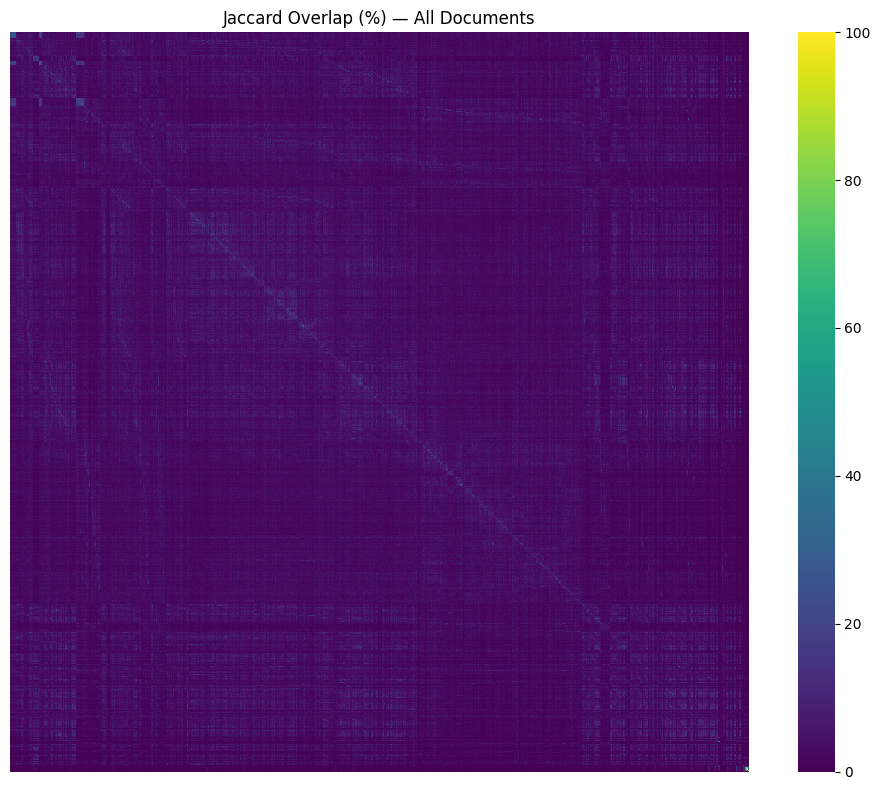

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_all.png
else part


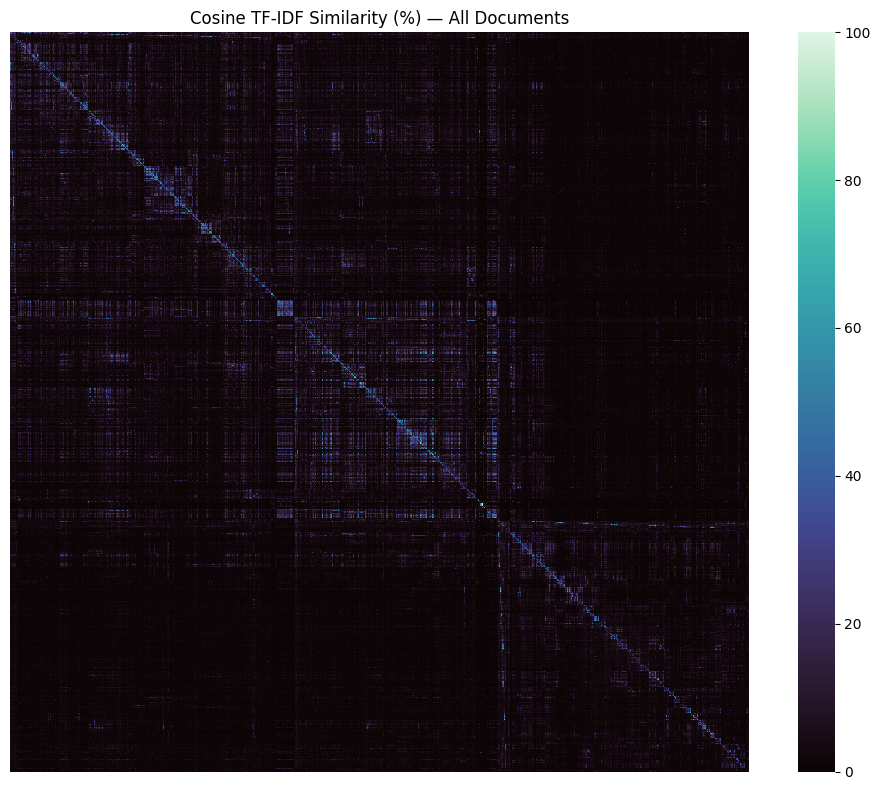

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_all.png


In [19]:
# Plots full heatmaps; for very large matrices, hide tick labels to keep rendering fast.

plot_heatmap(
    jaccard_df,
    title="Jaccard Overlap (%) — All Documents",
    out_name="heatmap_jaccard_all.png",
    vmin=0, vmax=100, cmap="viridis", annotate=False,
    add_ch_labels=False,
)

plot_heatmap(
    cosine_df,
    title="Cosine TF-IDF Similarity (%) — All Documents",
    out_name="heatmap_cosine_all.png",
    vmin=0, vmax=100, cmap="mako", annotate=False,
    add_ch_labels=False,
)


Jaccard overlap reveals that the three textbooks have extremely distinct vocabularies, with fewer than 5% shared unique terms across most document pairs. This indicates subject-specific terminology and minimal lexical reuse across domains.

Cosine similarity with TF-IDF weighting reveals richer structure in the textbook corpus compared to Jaccard overlap. The matrix contains visible diagonal block patterns corresponding to subject-specific clusters. Importantly, several cross-disciplinary similarity hotspots appear, reflecting overlapping conceptual themes such as thermodynamics (physics ↔ chemistry) and biomolecular structure (chemistry ↔ biology)

For Report:- "Jaccard analysis shows that physics, chemistry, and biology textbooks use largely non-overlapping vocabularies, confirming domain-specific terminology. However, cosine TF-IDF reveals deeper semantic relationships: despite low direct word overlap, several clusters show strong conceptual similarity, particularly between physics and chemistry (thermodynamics, energy systems) and between chemistry and biology (molecular and biochemical processes) but not between physics and biology, due to lack of similar topics."

In [17]:
# Slices matrices by prefix to visualize specific groups (intrabook) or cross-groups (interbook).

def rows_with_prefix(df, prefix):
    return [i for i in df.index if i.startswith(prefix)]

phys_chap = rows_with_prefix(jaccard_df, "physics_chapters/")
bio_chap = rows_with_prefix(jaccard_df, "chemistry_chapters/")
chem_chap = rows_with_prefix(jaccard_df, "biology_chapters/")
phys_pages = rows_with_prefix(jaccard_df, "physics_pages/")
bio_pages = rows_with_prefix(jaccard_df, "biology_pages/")
chem_pages = rows_with_prefix(jaccard_df, "chemistry_pages/")



if part


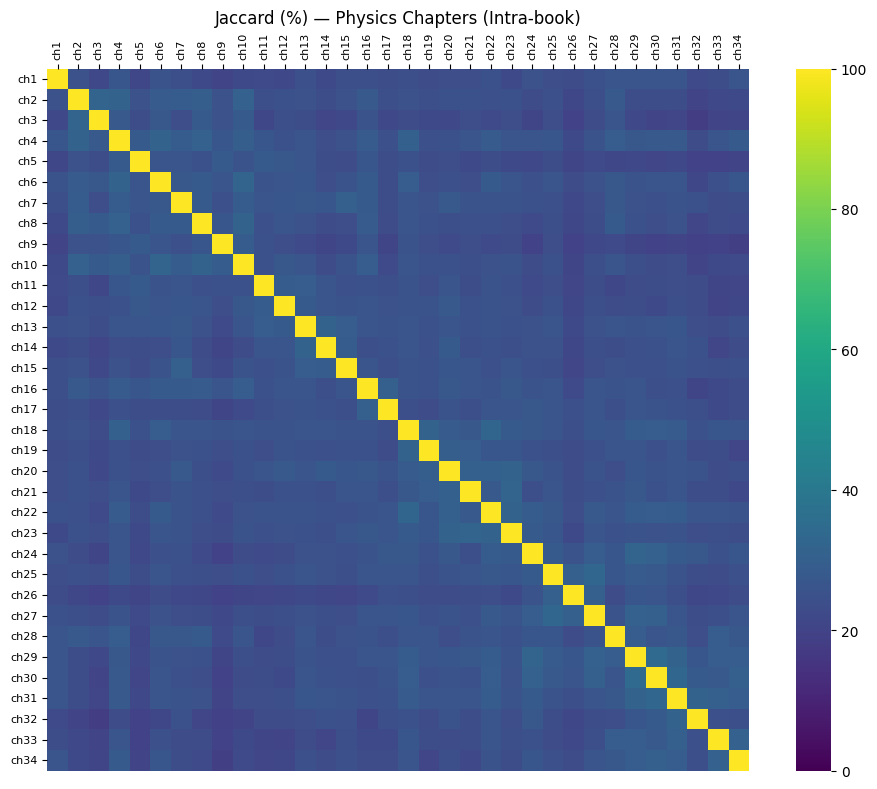

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_physics_chapters.png
if part


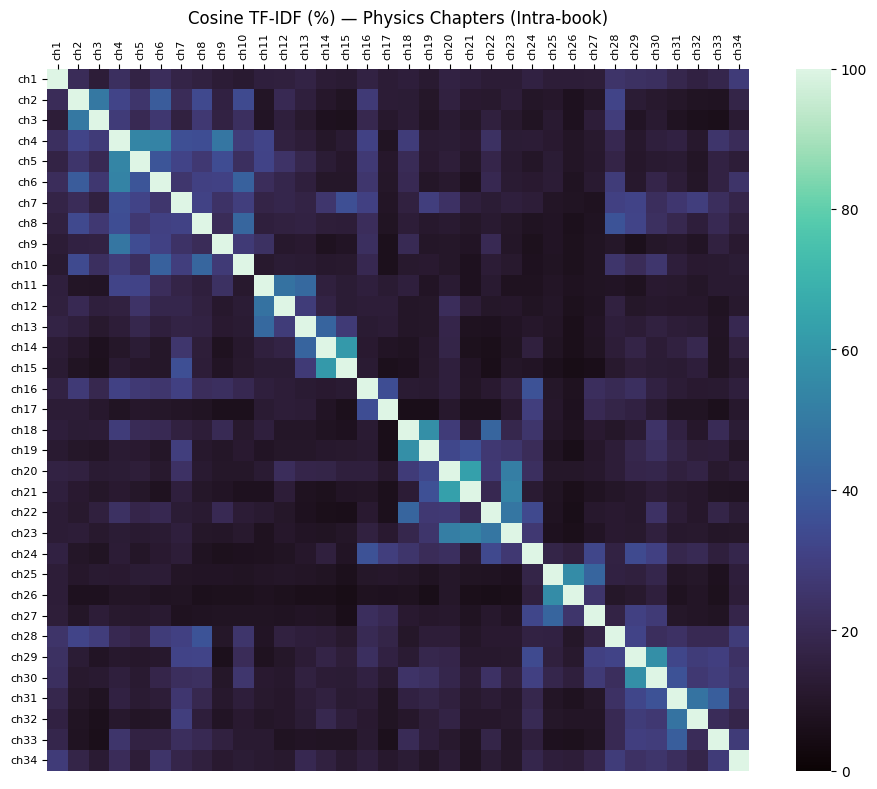

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_physics_chapters.png
if part


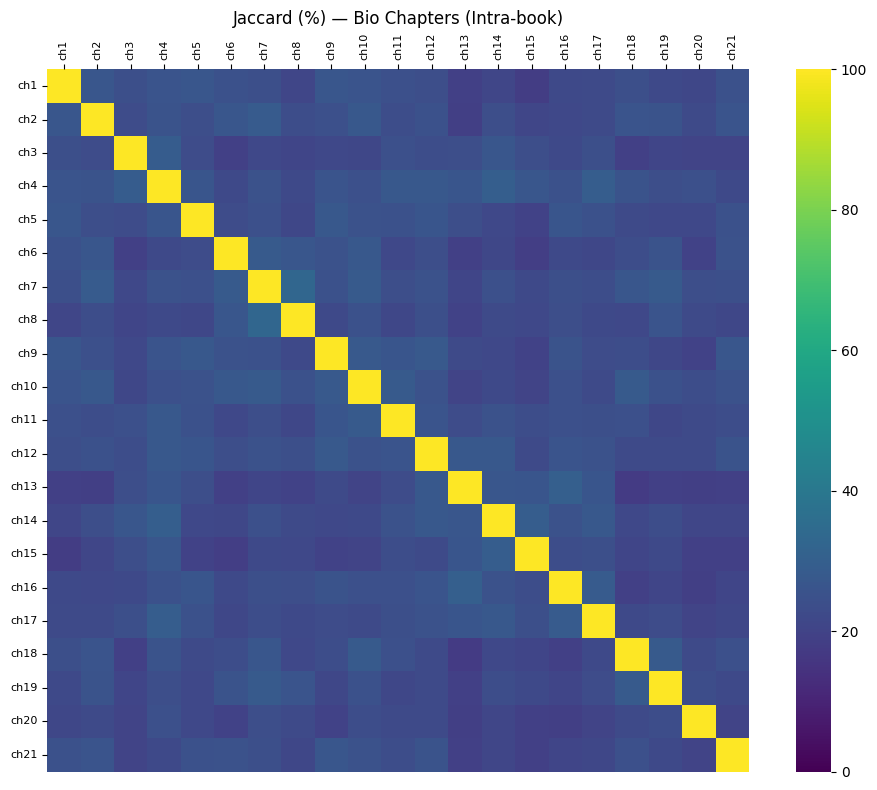

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_biology_chapters.png
if part


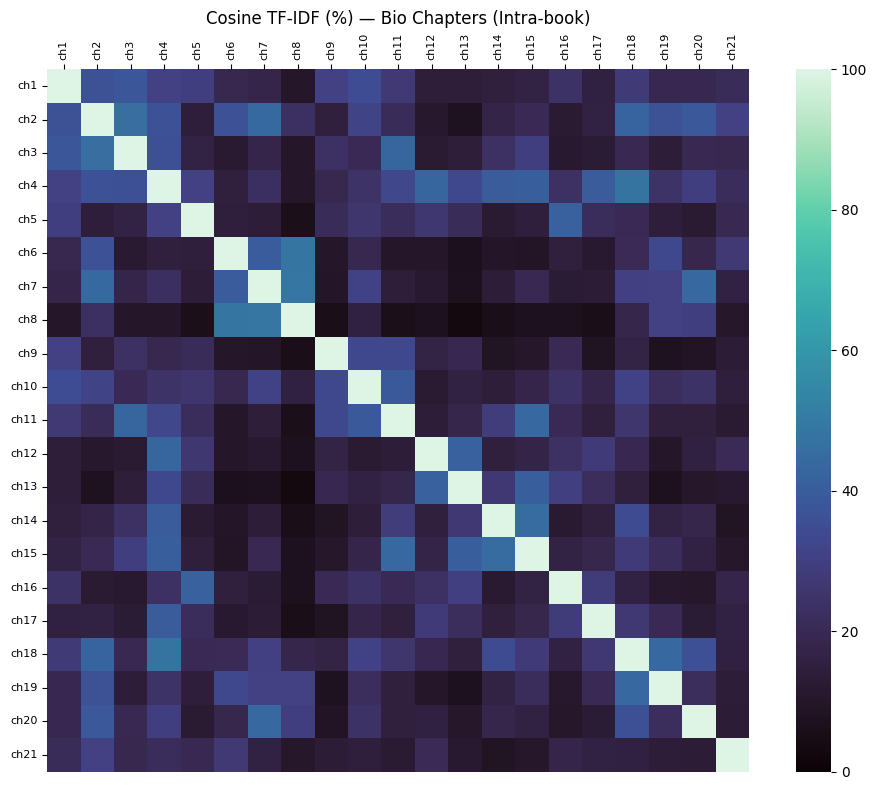

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_biology_chapters.png
if part


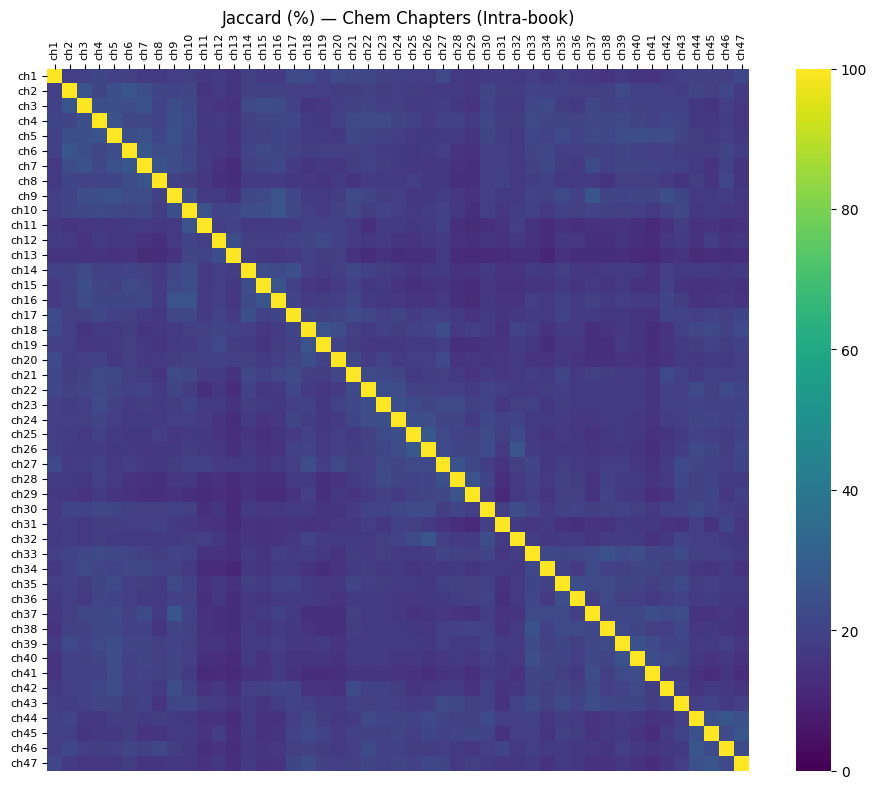

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_chemistry_chapters.png
if part


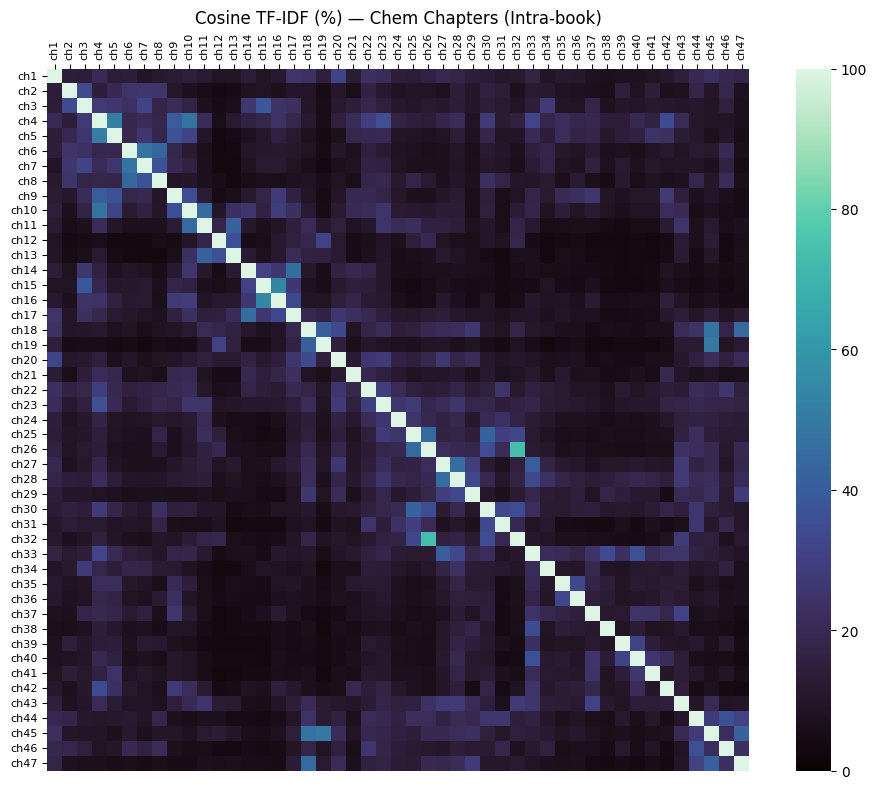

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_chemistry_chapters.png


In [18]:

# Intrabook: physics chapters only
plot_heatmap(
    jaccard_df.loc[phys_chap, phys_chap],
    title="Jaccard (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_jaccard_physics_chapters.png",
    vmin=0, vmax=100, cmap="viridis"
)

plot_heatmap(
    cosine_df.loc[phys_chap, phys_chap],
    title="Cosine TF-IDF (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_cosine_physics_chapters.png",
    vmin=0, vmax=100, cmap="mako"
)


# Intrabook: biology chapters only
plot_heatmap(
    jaccard_df.loc[bio_chap, bio_chap],
    title="Jaccard (%) — Bio Chapters (Intra-book)",
    out_name="heatmap_jaccard_biology_chapters.png",
    vmin=0, vmax=100, cmap="viridis"
)

plot_heatmap(
    cosine_df.loc[bio_chap, bio_chap],
    title="Cosine TF-IDF (%) — Bio Chapters (Intra-book)",
    out_name="heatmap_cosine_biology_chapters.png",
    vmin=0, vmax=100, cmap="mako"
)


# Intrabook: chemistry chapters only
plot_heatmap(
    jaccard_df.loc[chem_chap, chem_chap],
    title="Jaccard (%) — Chem Chapters (Intra-book)",
    out_name="heatmap_jaccard_chemistry_chapters.png",
    vmin=0, vmax=100, cmap="viridis"
)

plot_heatmap(
    cosine_df.loc[chem_chap, chem_chap],
    title="Cosine TF-IDF (%) — Chem Chapters (Intra-book)",
    out_name="heatmap_cosine_chemistry_chapters.png",
    vmin=0, vmax=100, cmap="mako"
)

When comparing the three subjects, we can see that:
- Vocabulary overlap (Jaccard) is uniformly low across all subjects. This indicates that physics, biology, and chemistry maintain strongly domain-specific terminologies.
- Conceptual overlap (cosine TF-IDF) reveals deeper relationships. TF-IDF uncovers meaningful cross-chapter and cross-domain patterns that Jaccard cannot detect, showing that STEM subjects share conceptual frameworks even when vocabularies differ.

In particular:
- Physics and chemistry share conceptual clusters around thermodynamics, energy, and system behavior.
- Chemistry and biology overlap conceptually in chapters addressing molecular structure, biochemical reactions, and cellular metabolism.
- Biology and physics show limited overlap but intersect around diffusion, entropy, and energy transformations.

else part


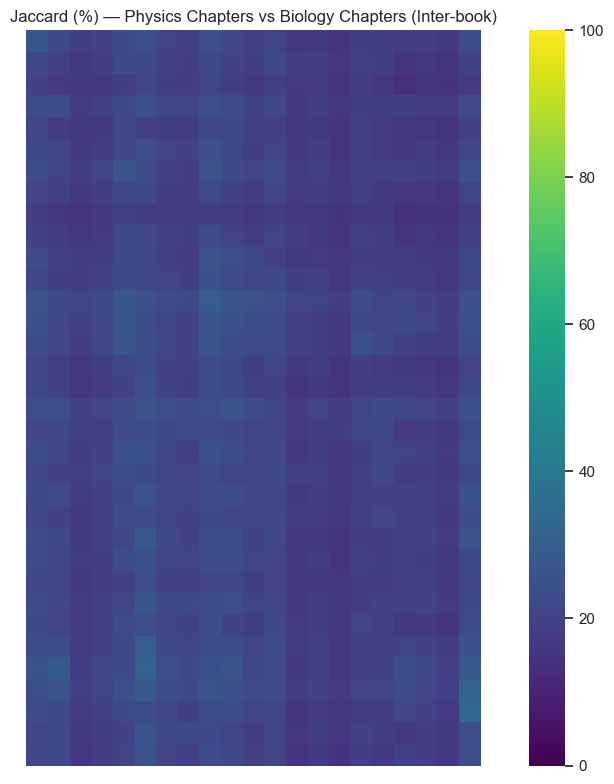

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_physchap_vs_bio_chap.png
else part


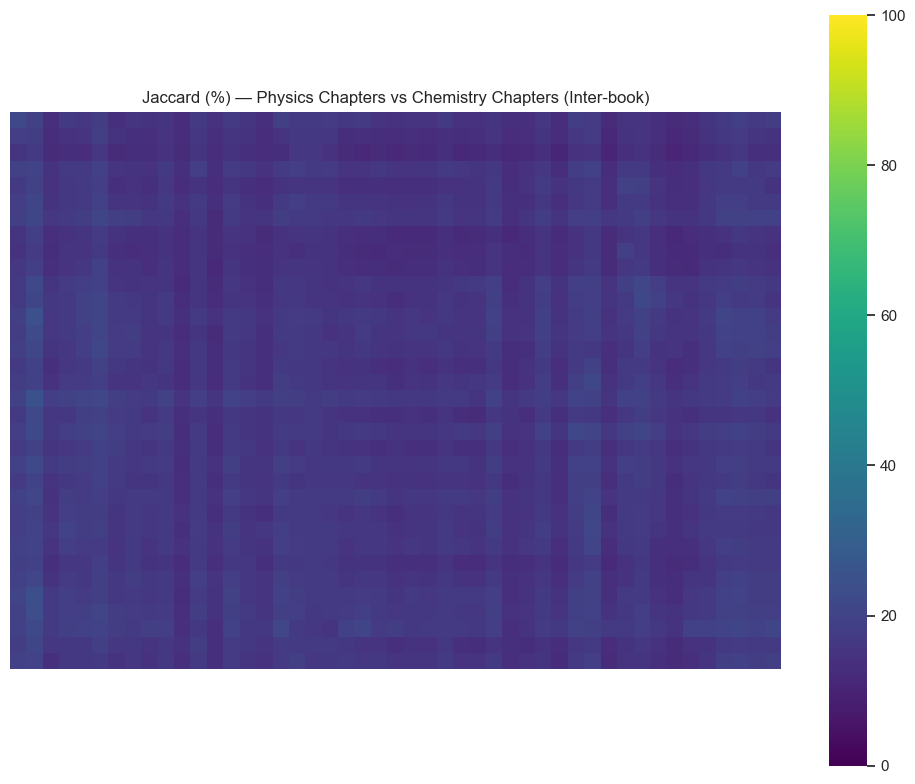

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_physchap_vs_chem_chap.png
else part


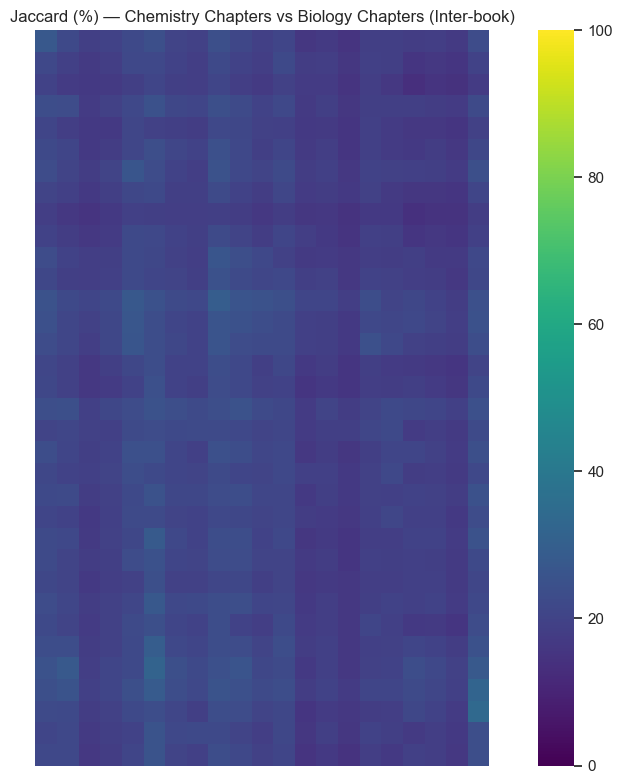

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_chemchap_vs_bio_chap.png


In [24]:
# Interbook: physics chapters vs biology pages
plot_heatmap(
    jaccard_df.loc[phys_chap, bio_chap],
    title="Jaccard (%) — Physics Chapters vs Biology Chapters (Inter-book)",
    out_name="heatmap_jaccard_physchap_vs_bio_chap.png",
    vmin=0, vmax=100, cmap="viridis",
    add_ch_labels=False,
)

# Interbook: physics chapters vs biology pages
plot_heatmap(
    jaccard_df.loc[phys_chap, chem_chap],
    title="Jaccard (%) — Physics Chapters vs Chemistry Chapters (Inter-book)",
    out_name="heatmap_jaccard_physchap_vs_chem_chap.png",
    vmin=0, vmax=100, cmap="viridis",
    add_ch_labels=False,
)

# Interbook: physics chapters vs biology pages
plot_heatmap(
    jaccard_df.loc[phys_chap, bio_chap],
    title="Jaccard (%) — Chemistry Chapters vs Biology Chapters (Inter-book)",
    out_name="heatmap_jaccard_chemchap_vs_bio_chap.png",
    vmin=0, vmax=100, cmap="viridis",
    add_ch_labels=False,
)

The physics–biology Jaccard matrix shows extremely low lexical overlap, indicating that the two subjects rely on almost entirely distinct terminology. This is expected given the fundamentally different domains of discourse: physics focuses on mathematical and mechanical constructs, whereas biology emphasizes cellular, ecological, and molecular terminology. The absence of bright clusters confirms the near lack of shared vocabulary across chapters.

The physics–chemistry Jaccard matrix shows marginally higher overlap than physics–biology, reflecting shared terminology in thermodynamics and energy-based descriptions. Nonetheless, overall lexical similarity remains low, consistent with the distinct conceptual focuses of the two disciplines—mathematical models in physics versus molecular interactions in chemistry.

The chemistry–biology Jaccard matrix exhibits the highest cross-subject lexical overlap among the three pairings. This aligns with the strong interface between molecular biology and chemistry, where discussions of reactions, molecular structure, bonding, and energy transformations share a common vocabulary. However, even here, overlap remains moderate, reflecting the broader diversity of topics within each textbook.

Across all subjects, vocabulary overlap (Jaccard) is consistently low, confirming that physics, chemistry, and biology maintain highly specialized and largely non-overlapping lexicons.

Physics ↔ Biology: lowest overlap <br>
Physics ↔ Chemistry: slightly higher <br>
Chemistry ↔ Biology: highest overlap (due to biochemistry link)

This result validates that the three textbooks are written for distinct conceptual domains, and that cross-subject conceptual relationships (revealed better by TF-IDF cosine similarity) cannot be captured through surface-level word overlap alone.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


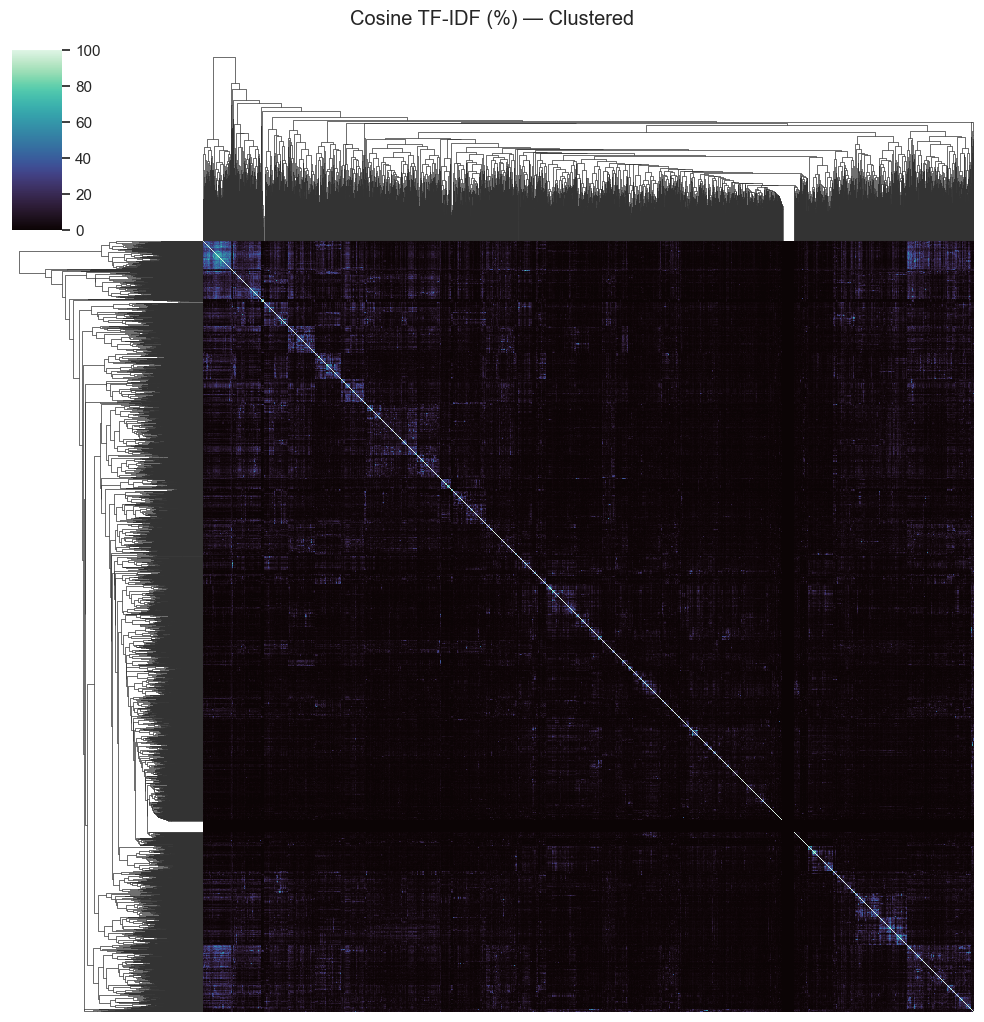

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/clustermap_cosine_all.png


In [21]:

sns.set(context="notebook")
g = sns.clustermap(
    cosine_df, cmap="mako", figsize=(10, 10),
    row_cluster=True, col_cluster=True,
    xticklabels=False, yticklabels=False
)
g.fig.suptitle("Cosine TF-IDF (%) — Clustered", y=1.02)
out_path = os.path.join(BASE, "_outputs", "clustermap_cosine_all.png")
g.savefig(out_path, dpi=300)
plt.show()
print("Saved figure →", out_path)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


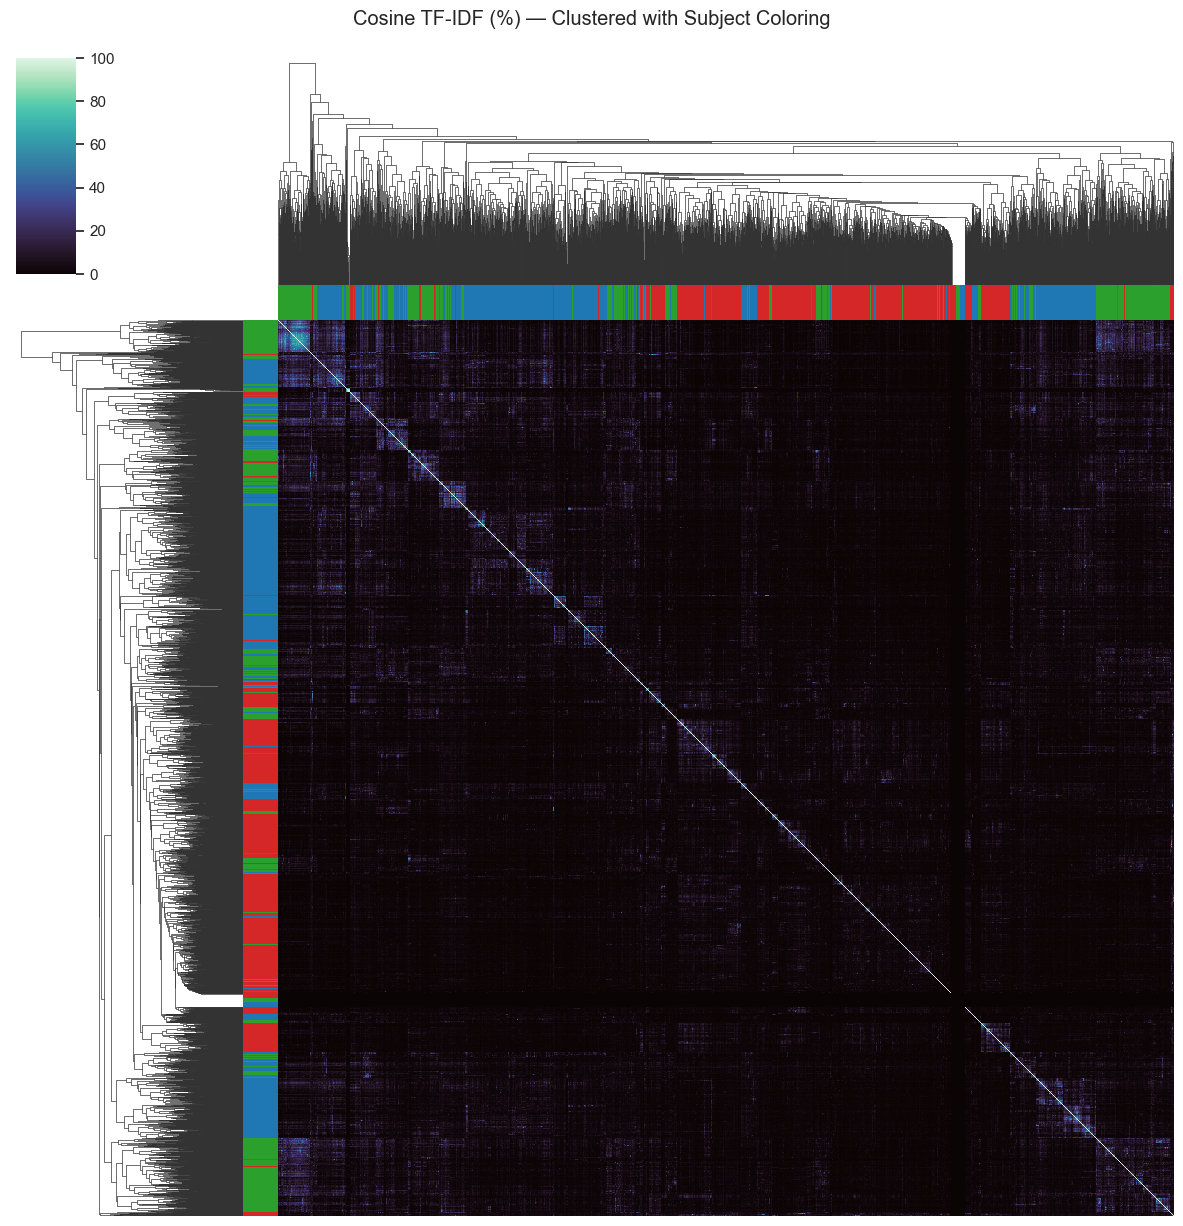

Saved: /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/clustermap_cosine_subjects.png


In [22]:
# Define subject-->color mapping
SUBJECT_COLORS = {
    "physics":   "#1f77b4",  # blue
    "chemistry": "#2ca02c",  # green
    "biology":   "#d62728",  # red
}

# Build color lists for rows/columns
row_colors = []
for name in cosine_df.index:
    if name.startswith("physics"):
        row_colors.append(SUBJECT_COLORS["physics"])
    elif name.startswith("chemistry"):
        row_colors.append(SUBJECT_COLORS["chemistry"])
    elif name.startswith("biology"):
        row_colors.append(SUBJECT_COLORS["biology"])
    else:
        row_colors.append("gray")   # fallback

col_colors = row_colors  # same ordering

# Now plot the clustermap
sns.set(context="notebook")
g = sns.clustermap(
    cosine_df,
    cmap="mako",
    figsize=(12, 12),
    row_cluster=True,
    col_cluster=True,
    xticklabels=False,
    yticklabels=False,
    row_colors=row_colors,
    col_colors=col_colors
)

g.fig.suptitle("Cosine TF-IDF (%) — Clustered with Subject Coloring", y=1.02)

out_path = os.path.join(BASE, "_outputs", "clustermap_cosine_subjects.png")
g.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


Hierarchical clustering algorithm is being applied. This algorithm reorders the chapters/pages so that similar documents are placed next to each other. <br>
I have now included the chapter numbering so that it's much easier to understand.


Physics = Blue <br>
Chemistry = Green <br> 
Biology = Red  <br>



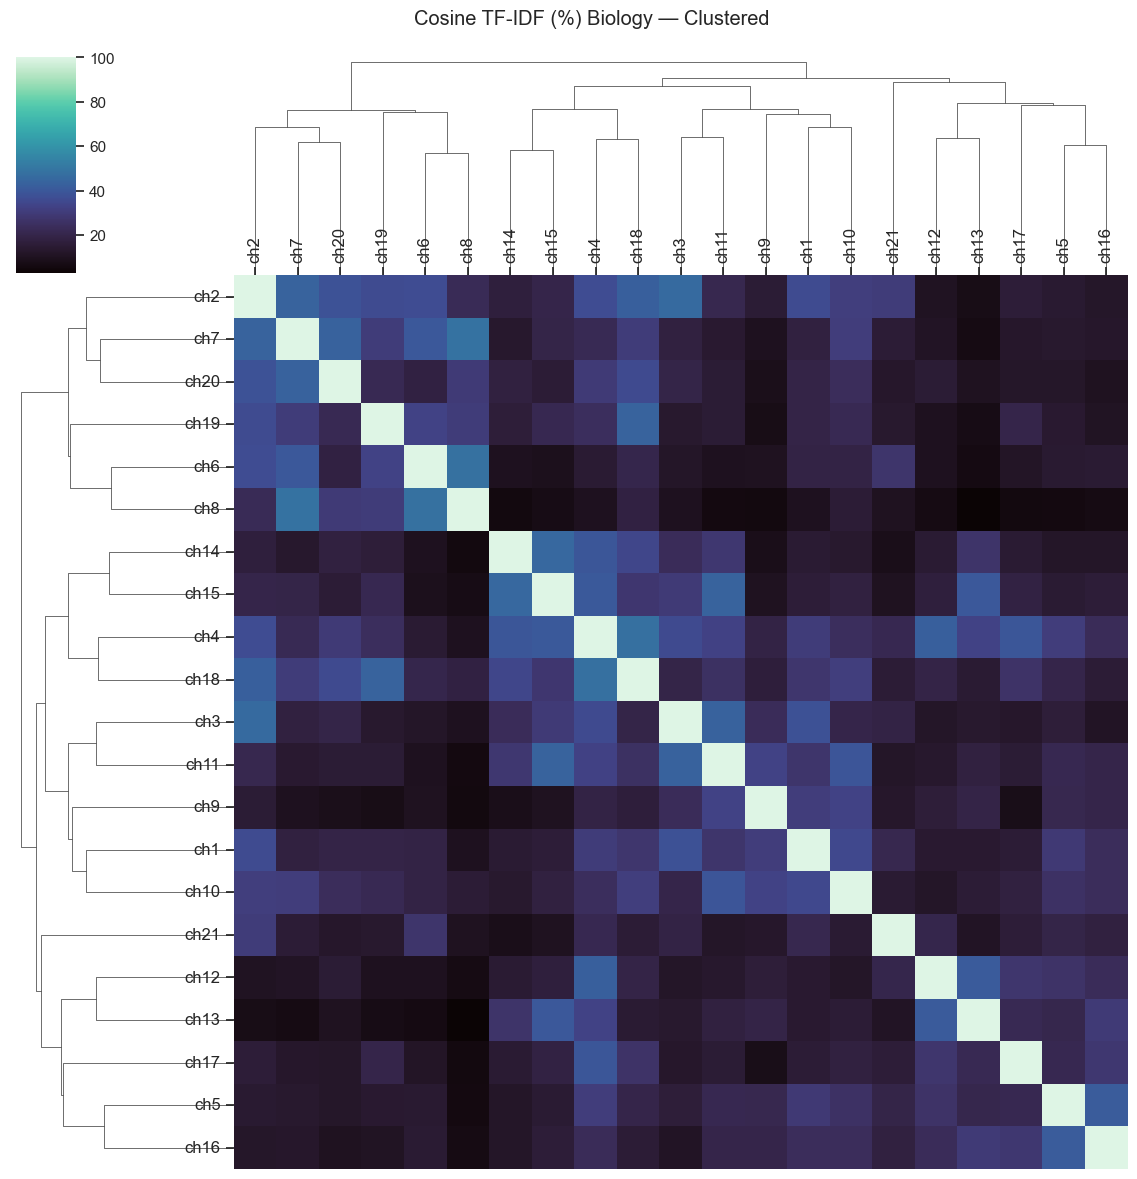

Saved → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/clustermap_cosine_bio_ch.png


In [25]:
sns.set(context="notebook")

df = cosine_df.loc[bio_chap, bio_chap]

# Short labels
short_labels = [f"ch{i+1}" for i in range(len(df))]

# rename
df_short = df.copy()
df_short.index = short_labels
df_short.columns = short_labels

# cluster
g = sns.clustermap(
    df_short,
    cmap="mako",
    figsize=(12, 12),
    row_cluster=True,
    col_cluster=True,
    xticklabels=True,
    yticklabels=True
)

# Move labels to top/left
g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.xaxis.tick_top()

# Style labels
g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(),
    fontsize=12,
    rotation=90
)
g.ax_heatmap.set_yticklabels(
    g.ax_heatmap.get_yticklabels(),
    fontsize=12
)

# Title + save
g.fig.suptitle("Cosine TF-IDF (%) Biology — Clustered", y=1.02)
out_path = os.path.join(BASE, "_outputs", "clustermap_cosine_bio_ch.png")
g.savefig(out_path, dpi=300)
plt.show()

print("Saved →", out_path)


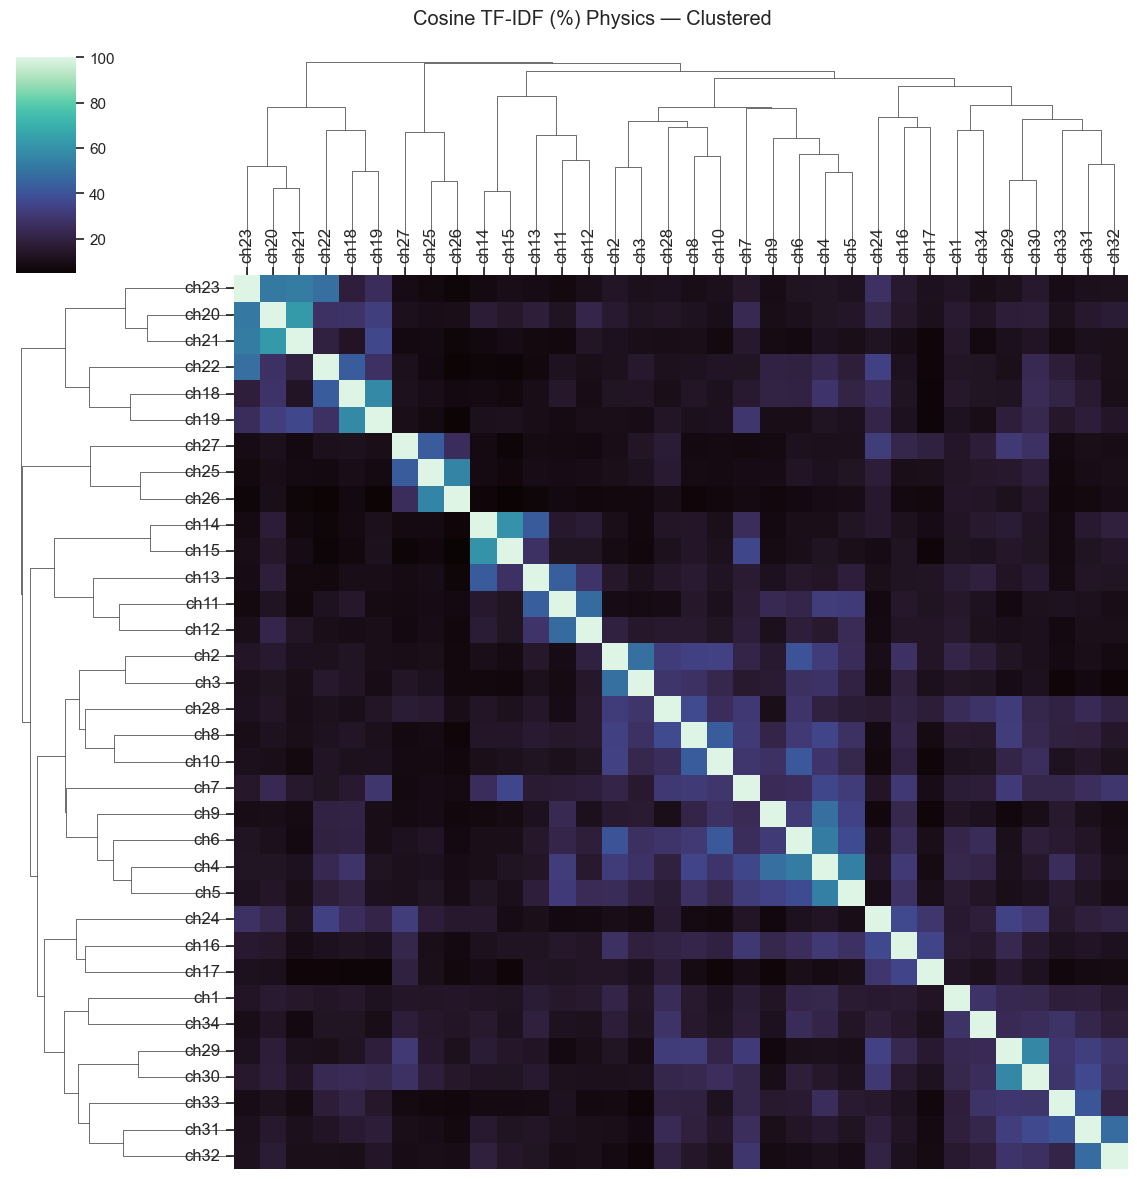

Saved → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/clustermap_cosine_phy_ch.png


In [26]:
sns.set(context="notebook")

df = cosine_df.loc[phys_chap, phys_chap]

# Short labels
short_labels = [f"ch{i+1}" for i in range(len(df))]

# rename
df_short = df.copy()
df_short.index = short_labels
df_short.columns = short_labels

# cluster
g = sns.clustermap(
    df_short,
    cmap="mako",
    figsize=(12, 12),
    row_cluster=True,
    col_cluster=True,
    xticklabels=True,
    yticklabels=True
)

# Move labels to top/left
g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.xaxis.tick_top()

# Style labels
g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(),
    fontsize=12,
    rotation=90
)
g.ax_heatmap.set_yticklabels(
    g.ax_heatmap.get_yticklabels(),
    fontsize=12
)

# Title + save
g.fig.suptitle("Cosine TF-IDF (%) Physics — Clustered", y=1.02)
out_path = os.path.join(BASE, "_outputs", "clustermap_cosine_phy_ch.png")
g.savefig(out_path, dpi=300)
plt.show()

print("Saved →", out_path)


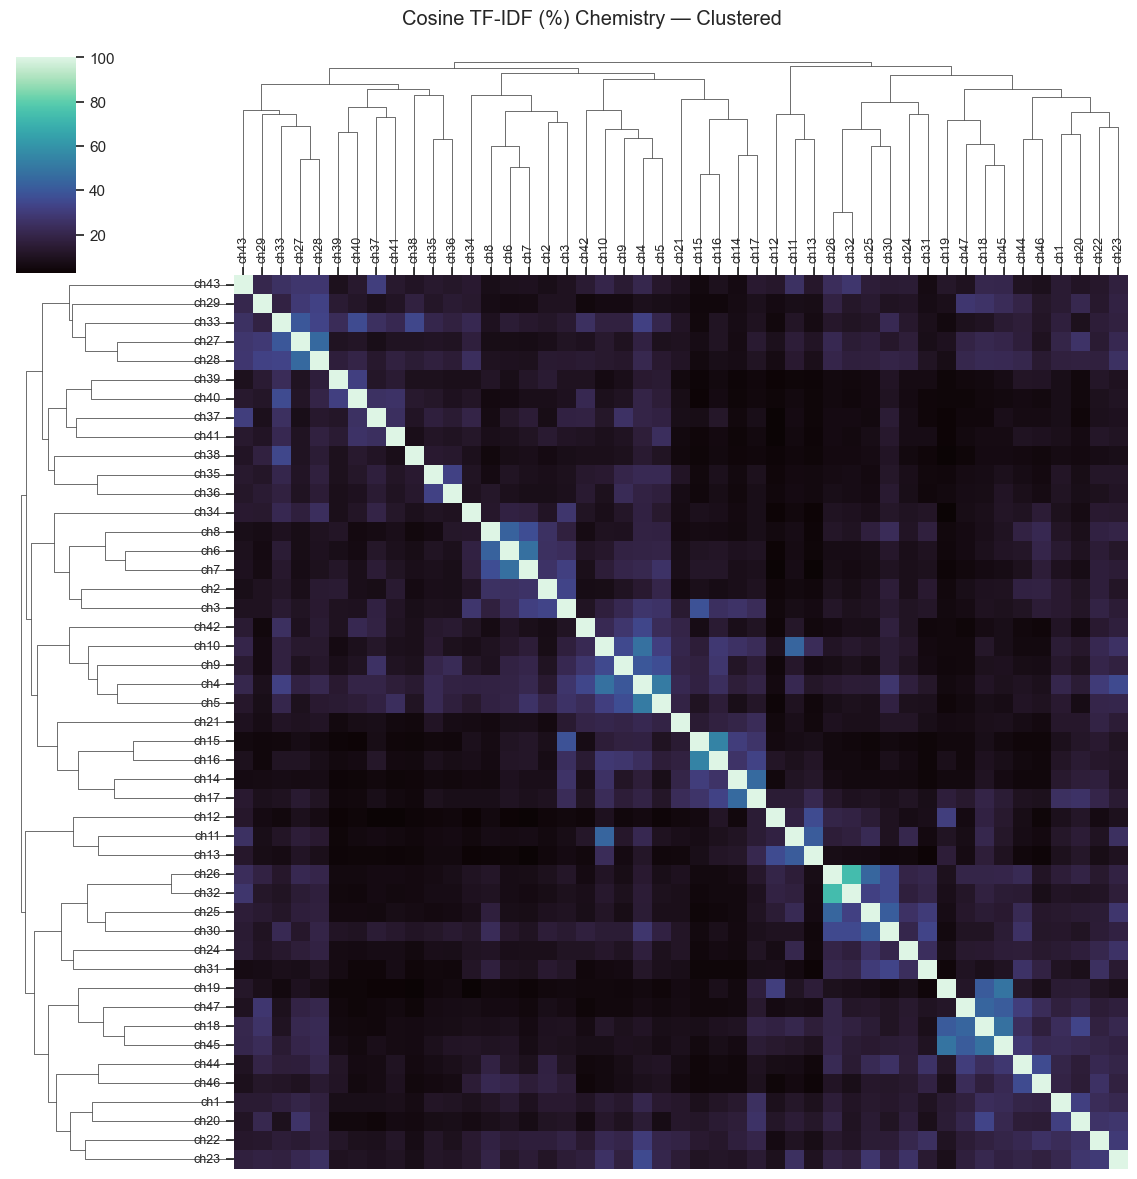

Saved → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/clustermap_cosine_chem_ch.png


In [27]:
sns.set(context="notebook")

df = cosine_df.loc[chem_chap, chem_chap]

# Short labels
short_labels = [f"ch{i+1}" for i in range(len(df))]

# rename
df_short = df.copy()
df_short.index = short_labels
df_short.columns = short_labels

# cluster
g = sns.clustermap(
    df_short,
    cmap="mako",
    figsize=(12, 12),
    row_cluster=True,
    col_cluster=True,
    xticklabels=True,
    yticklabels=True
)

# Move labels to top/left
g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.xaxis.tick_top()

# Style labels
g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(),
    fontsize=9,
    rotation=90
)
g.ax_heatmap.set_yticklabels(
    g.ax_heatmap.get_yticklabels(),
    fontsize=9
)

# Title + save
g.fig.suptitle("Cosine TF-IDF (%) Chemistry — Clustered", y=1.02)
out_path = os.path.join(BASE, "_outputs", "clustermap_cosine_chem_ch.png")
g.savefig(out_path, dpi=300)
plt.show()

print("Saved →", out_path)


Separate clustermaps for each textbook further reveal the internal semantic organization of individual subjects. Biology exhibits the strongest and densest clusters, particularly within molecular biology, cellular processes, metabolism, and genetics, reflecting the inherently interconnected nature of biochemical mechanisms. Physics forms well-defined clusters around mechanics, electromagnetism, waves, and thermodynamics, highlighting the progressive, hierarchical structure of physical concepts. Chemistry similarly shows robust clusters corresponding to bonding, molecular structure, equilibrium, kinetics, and thermodynamics. In all three cases, TF-IDF weighting amplifies key terminology within each topic area, allowing the clustering algorithm to effectively group chapters based on their dominant scientific themes. These intra-subject clustermaps confirm the strong internal coherence of each textbook.

– Closer branches = more similar <br>
– Taller merges = less similar

In [21]:

def top_k_neighbors(sim_df, k=5):
    rows = []
    for i, row in sim_df.iterrows():
        # drop self-similarity then take top-k
        sr = row.drop(labels=[i], errors="ignore").sort_values(ascending=False).head(k)
        for j, val in sr.items():
            rows.append({"doc": i, "neighbor": j, "score_percent": round(float(val), 2)})
    return pd.DataFrame(rows)

nn_cosine = top_k_neighbors(cosine_df, k=5)
nn_jaccard = top_k_neighbors(jaccard_df, k=5)

nn_cosine.head(10)
nn_cosine.tail(10)


doc                        neighbor  \
22165  biology_pages/page_1486.md      biology_pages/page_0458.md   
22166  biology_pages/page_1486.md      biology_pages/page_0443.md   
22167  biology_pages/page_1486.md  biology_chapters/chapter_16.md   
22168  biology_pages/page_1486.md      biology_pages/page_0457.md   
22169  biology_pages/page_1486.md      biology_pages/page_1336.md   
22170  biology_pages/page_1487.md      biology_pages/page_0711.md   
22171  biology_pages/page_1487.md      biology_pages/page_0720.md   
22172  biology_pages/page_1487.md      biology_pages/page_0719.md   
22173  biology_pages/page_1487.md      biology_pages/page_0893.md   
22174  biology_pages/page_1487.md      biology_pages/page_0889.md   

       score_percent  
22165          15.64  
22166          15.53  
22167          15.26  
22168          13.02  
22169          12.06  
22170          15.79  
22171          15.37  
22172          14.93  
22173          14.77  
22174          14.01

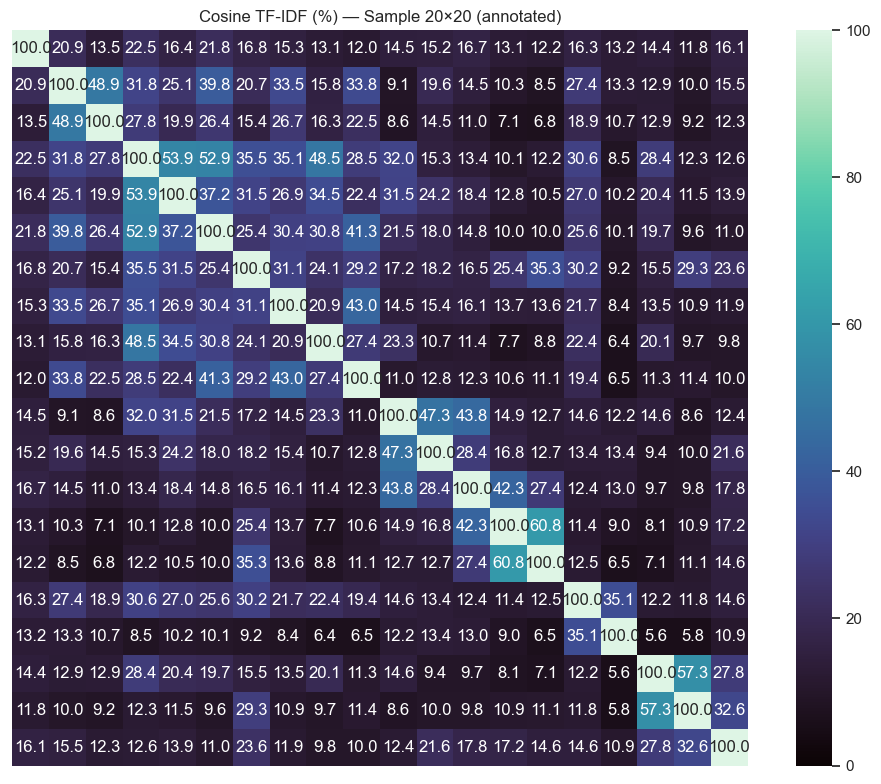

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_sample_annot.png


In [22]:
# For small subsets (e.g., 20x20).

subset = cosine_df.iloc[:20, :20]
plot_heatmap(
    subset,
    title="Cosine TF-IDF (%) — Sample 20×20 (annotated)",
    out_name="heatmap_cosine_sample_annot.png",
    vmin=0, vmax=100, cmap="mako", annotate=True
)
